<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# RNN Text Classifier

by Fabian Märki

## Summary
The aim of this notebook is to build a RNN text classifier. It utilize pretrained word embeddings in order to take advantage of [transfer learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning) in NLP. Additionally, it sets the stage for hyperparameter tuning and model design optimization.

## Links
- [Enabling GPU on Google Colab](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm)

This notebook contains assigments: <font color='red'>Questions are written in red.</font>

<a href="https://colab.research.google.com/github/markif/2022_HS_DAS_NLP_Notebooks/blob/master/06_a_RNN_Text_Classifier.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.4.8,<0.5.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.colab import runs_on_colab

import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.15.0-46-generic
Python version: 3.6.9
CPU cores: 6
RAM: 31.12GB total and 25.41GB available
Tensorflow version: 2.5.1
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


Download the [cleaned](https://github.com/markif/2022_FS_CAS_NLP_LAB_Notebooks/blob/master/02_a_Text_Cleaning.ipynb) and [preprocessed](https://github.com/markif/2022_FS_CAS_NLP_LAB_Notebooks/blob/master/02_b_Text_Normalization.ipynb) doctor reviews dataset. 

In [3]:
%%time
download("https://drive.google.com/uc?id=19AFeVnOfX8WXU4_3rM7OFoNTWWog_sb_", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

CPU times: user 8.04 s, sys: 1.35 s, total: 9.39 s
Wall time: 5.59 s


Exclude *neutral* ratings so that the task becomes a binary classification.

In [4]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [5]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


Import some helper functions...

In [6]:
from fhnw.nlp.utils.ploting import plot_history

from fhnw.nlp.utils.params import build_model_cnn
from fhnw.nlp.utils.params import build_model_rnn
from fhnw.nlp.utils.params import compile_model
from fhnw.nlp.utils.params import create_label_binarizer_and_set
from fhnw.nlp.utils.params import dataframe_to_dataset
from fhnw.nlp.utils.params import extract_embedding_layer_and_set
from fhnw.nlp.utils.params import extract_text_vectorization_and_set
from fhnw.nlp.utils.params import extract_vocabulary_and_set
from fhnw.nlp.utils.params import get_train_test_split
from fhnw.nlp.utils.params import re_compile_model
from fhnw.nlp.utils.params import save_model
from fhnw.nlp.utils.params import train_model

Setup the *params* dictionary which is used to specify hyperparameters and model design choices (and is also used to store intermediate results).  This sets the stage for a possible hyperparameter tuning and model design optimization (not part of this notebook).

<font color='red'>**TASK: You might want to try different *word embeddings* by changing the `embedding_type` parameter (values: *fasttext*, *bytepair*, *word2vec*).**</font>

In [7]:
params = {
    "verbose": True,
    "shuffle": True,
    # modify batch_size in case you experience memory issues
    "batch_size": 128,
    "X_column_name": "text_clean",
    "y_column_name": "label",
    # modify to try different word embeddings
    "embedding_type": "fasttext",
    "embedding_dim": 300,
    "embedding_trainable": False,
    "embedding_fasttext_model": "cc.de.300.bin",
    "embedding_word2vec_model_url": "https://cloud.devmount.de/d2bc5672c523b086/german.model",
    "embedding_spacy_model": "de_core_news_md",
    "embedding_tensorflow_hub_url": "https://tfhub.dev/google/nnlm-de-dim128-with-normalization/2",
    "model_type": "rnn",
}

if runs_on_colab() and params["embedding_type"] == "fasttext":
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.google.com/uc?id=1iqw8UPEEVmzQQGmI5FkRJH8B5SkZCgXG", model_name)
    params["embedding_dim"] = 50
    params["embedding_fasttext_model"] = model_name
    

...extract the vocabulary...

In [8]:
create_label_binarizer_and_set(params, data)
extract_vocabulary_and_set(params, data)

Inferred classification type: binary
Median sequence length: 46
Percentil (0.98) cutoff sequence length: 230
Max sequence length: 408
Used embedding sequence length: 230


...build the TextVectorization layer...

In [9]:
extract_text_vectorization_and_set(params)

Vocabulary length: 189790


...import and load word embeddings...

In [10]:
%%time

extract_embedding_layer_and_set(params)

Embedding type: fasttext
Number of null word embeddings: 9
Words not found in total: 9
Words without embedding (9/9): ['ìn', '', 'úm', 'öz', 'èn', 'üw', 'öä', 'jé', 'äk']
CPU times: user 6.59 s, sys: 4.31 s, total: 10.9 s
Wall time: 14.8 s


...prepare the training/test/validation data...

In [11]:
data_train, data_test = get_train_test_split(params, data)
data_train, data_val = get_train_test_split(params, data_train)

dataset_train = dataframe_to_dataset(params, data_train)
dataset_test = dataframe_to_dataset(params, data_test)
dataset_val = dataframe_to_dataset(params, data_val)

264949 train examples
66238 test examples
211959 train examples
52990 test examples


In [12]:
for text, labels in dataset_train.take(1):
    print(text)
    print(labels)

{'text_clean': <tf.Tensor: shape=(128,), dtype=string, numpy=
array([b'meine schmerzen wurden behoben , die f\xc3\xbcllungen ersetzt bzw . korrigiert . das ergebnis war sehr gut , farbe und form sehr nat\xc3\xbcrlich . hr . butz war bzgl . risiken und kosten stets sehr offen und transparent .',
       b'die termine und behandlungen bei dr. schmid sind sachlich , kompetent und freundlich . dies trifft genauso f\xc3\xbcr frau dr. habermann zu . das personal ist entgegen manchen bewertungen hier stets freundlich und offen f\xc3\xbcr einen joke . kann nicht negatives , egal von welcher seite , berichten . wie hei\xc3\x9ft ein sprichwort wie man in den wald ruft',
       b'das praxispersonal scheint mit einer sinnvollen terminvergabe \xc3\xbcberfordert zu sein . einmal im behandlungszimmer angekommen nimmt sich der arzt viel zeit .',
       b'ich gehe schon seit jahren zu frau dr. gr\xc3\xb6ber pohl und war immer sehr zufrieden . zu beginn war ich noch privat patientin , nun bin ich gesetzl

<font color='red'>**TASK: Improve the RNN model defined in `build_model_rnn` (play with rnn_units, activation function, rnn type ([RNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/), [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/), [GRU](https://keras.io/api/layers/recurrent_layers/gru/)), model design ([Bidirectional](https://keras.io/api/layers/recurrent_layers/bidirectional/), [Multi-Layer RNN](https://wandb.ai/lavanyashukla/visualize-models/reports/How-to-stack-multiple-LSTMs-in-keras---VmlldzoxOTg2MTY) ) etc...)**</font>

You might get inspiration from:
- [Working with RNNs](https://keras.io/guides/working_with_rnns/)
- [Develop a Bidirectional LSTM For Sequence Classification](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/)

In [13]:
def build_model_rnn(params):
    """Builds a rnn classifier (only partially) based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    from tensorflow import keras
    
    # choose the output activation function based on the classification type
    classification_type = params.get("classification_type", "binary")
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise TypeError("Unknown classification_type "+classification_type)
    
    X_column_name = params.get("X_column_name", "text_clean")
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1
    
    
    model = keras.Sequential(name="rnn")
    # A text input layer
    model.add(keras.layers.InputLayer(input_shape=(1,), dtype=tf.string, name=X_column_name))
    # The first layer in our model is the vectorization layer. After this layer,
    # we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model.add(vectorize_layer)
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'. 
    model.add(embedding_layer)
    
    # build the RNN
    rnn_units = 32
    model.add(keras.layers.Bidirectional(
        # dropout (regularization) could make sense here
        keras.layers.LSTM(
            rnn_units, 
            return_sequences=True # needed since we do a GlobalMaxPool1D
        )
    ))
    # add global max pooling
    model.add(keras.layers.GlobalMaxPool1D(name="global_max_pool"))
    
    # do not forget Dropout (regularization) for a more sophisticated model
    
    # add the classification head
    model.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))
    
    return model

**Note: The run you see below is from a build_model_rnn(...) model (i.e. your output might look different)!**

In [14]:
model = build_model_rnn(params)
model.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         56937000  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          85248     
_________________________________________________________________
global_max_pool (GlobalMaxPo (None, 64)                0         
_________________________________________________________________
prediction (Dense)           (None, 1)                 65        
Total params: 57,022,313
Trainable params: 85,313
Non-trainable params: 56,937,000
_________________________________________________________________


In [15]:
compile_model(params, model)

In [16]:
params["training_epochs"] = 10
history = train_model(params, model, dataset_train, dataset_val)

Epoch 1/10
1656/1656 [==============================] - 63s 34ms/step - loss: 0.0883 - accuracy: 0.9661 - val_loss: 0.0574 - val_accuracy: 0.9788
Epoch 2/10
1656/1656 [==============================] - 55s 33ms/step - loss: 0.0514 - accuracy: 0.9812 - val_loss: 0.0641 - val_accuracy: 0.9747
Epoch 3/10
1656/1656 [==============================] - 55s 33ms/step - loss: 0.0439 - accuracy: 0.9839 - val_loss: 0.0493 - val_accuracy: 0.9831
Epoch 4/10
1656/1656 [==============================] - 55s 33ms/step - loss: 0.0384 - accuracy: 0.9862 - val_loss: 0.0488 - val_accuracy: 0.9829
Epoch 5/10
1656/1656 [==============================] - 55s 33ms/step - loss: 0.0340 - accuracy: 0.9882 - val_loss: 0.0493 - val_accuracy: 0.9832
Epoch 6/10
1656/1656 [==============================] - 54s 32ms/step - loss: 0.0295 - accuracy: 0.9897 - val_loss: 0.0543 - val_accuracy: 0.9813
Epoch 7/10
1656/1656 [==============================] - 53s 32ms/step - loss: 0.0256 - accuracy: 0.9913 - val_loss: 0.0587 -

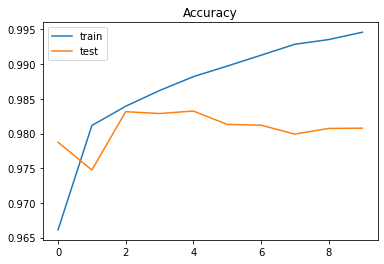

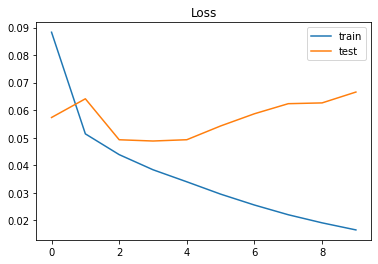

In [17]:
plot_history(history)

Quite overfitted. Training could stop after ~3 epochs and some regularizations (like dropout) could also make sense.  

Let's see if it is possible to further improve the model by unfreezing the embedding layer.

Also see https://www.tensorflow.org/guide/keras/transfer_learning

In [18]:
# Unfreeze all layers (i.e. make embeddings trainable)
model.trainable = True
model.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         56937000  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          85248     
_________________________________________________________________
global_max_pool (GlobalMaxPo (None, 64)                0         
_________________________________________________________________
prediction (Dense)           (None, 1)                 65        
Total params: 57,022,313
Trainable params: 57,022,313
Non-trainable params: 0
_________________________________________________________________


In [19]:
re_compile_model(params, model)

In [20]:
params["training_epochs"] = 2
history = train_model(params, model, dataset_train, dataset_val)

Epoch 1/2
1656/1656 [==============================] - 718s 430ms/step - loss: 0.0108 - accuracy: 0.9968 - val_loss: 0.0634 - val_accuracy: 0.9819
Epoch 2/2
1656/1656 [==============================] - 701s 424ms/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0635 - val_accuracy: 0.9820


In [21]:
save_model(params, model, history)

INFO:tensorflow:Assets written to: models/rnn/20220828-161534/model_0.98200/assets


In [23]:
from fhnw.nlp.utils.ploting import report_classification_results

Check performance on all data.

Set Population: 331187
Accuracy: 0.9929


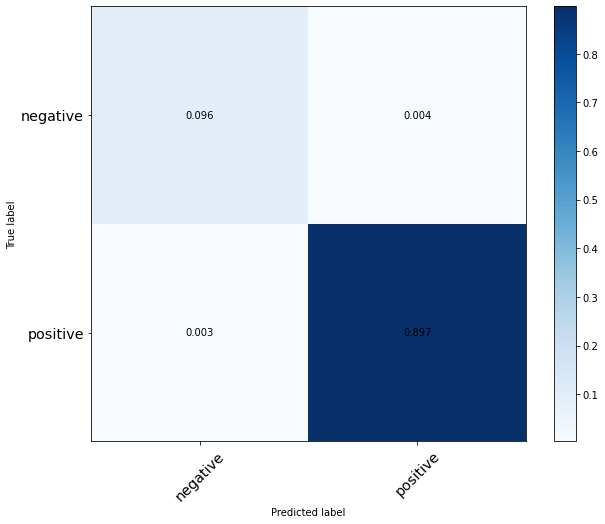

              precision    recall  f1-score   support

    negative       0.97      0.96      0.96     33022
    positive       1.00      1.00      1.00    298165

    accuracy                           0.99    331187
   macro avg       0.98      0.98      0.98    331187
weighted avg       0.99      0.99      0.99    331187

CPU times: user 1min 58s, sys: 1.38 s, total: 2min
Wall time: 46.1 s


In [24]:
%%time

report_classification_results(params, data, model)

Check performance on test data.

Set Population: 66238
Accuracy: 0.9821


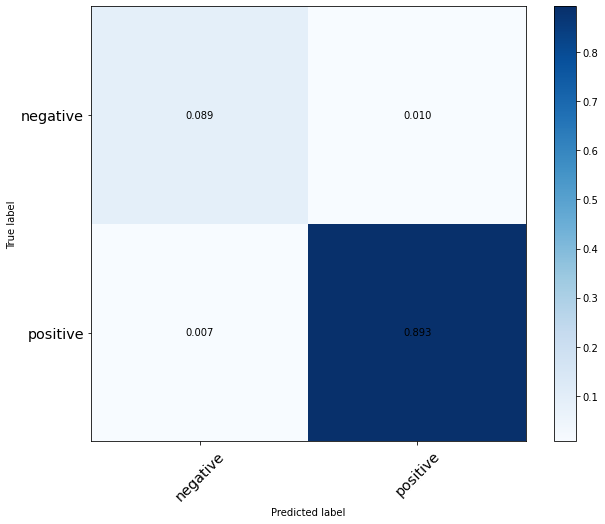

              precision    recall  f1-score   support

    negative       0.92      0.90      0.91      6604
    positive       0.99      0.99      0.99     59634

    accuracy                           0.98     66238
   macro avg       0.96      0.94      0.95     66238
weighted avg       0.98      0.98      0.98     66238

CPU times: user 23.8 s, sys: 286 ms, total: 24.1 s
Wall time: 9.62 s


In [25]:
%%time

report_classification_results(params, data_test, model)